In [140]:
import weaviate

# <== if you use Docker-compose
client = weaviate.Client("http://localhost:8080")


## Data Exploration


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()


In [142]:
df = pd.read_csv("./data/germeval2018.training.txt", delimiter="\t",
                 header=None, names=["Tweet", "Primary_Category", "Secondary_Category"])
df.head()


,Tweet,Primary_Category,Secondary_Category
0,"@corinnamilborn Liebe Corinna, wir würden dich...",OTHER,OTHER
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,OTHER,OTHER
2,@ahrens_theo fröhlicher gruß aus der schönsten...,OTHER,OTHER
3,@dushanwegner Amis hätten alles und jeden gewä...,OTHER,OTHER
4,@spdde kein verläßlicher Verhandlungspartner. ...,OFFENSE,INSULT


<AxesSubplot: >

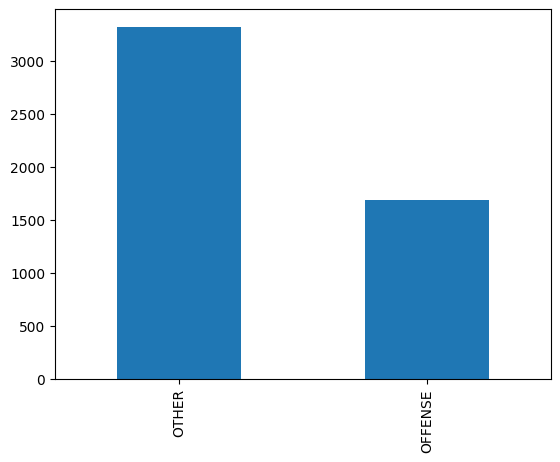

In [143]:
df.Primary_Category.value_counts().plot.bar()


<AxesSubplot: >

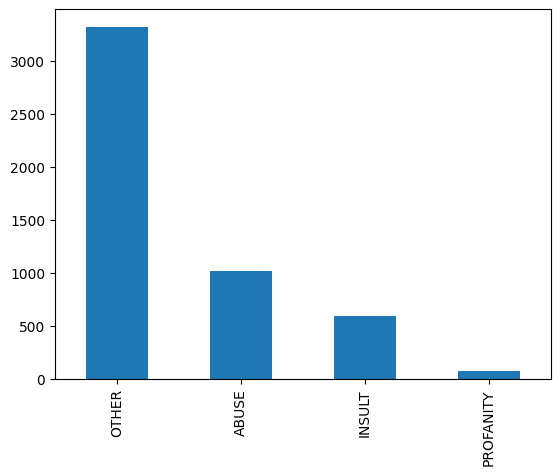

In [144]:
df.Secondary_Category.value_counts().plot.bar()


## Data Cleansing


In [145]:
import re


def retrieve_hashtags(text: str, regex = r"\B(\#[a-zA-Z_\-0-9]+\b)"):
    return re.findall(regex, text)

def remove_hashtags(text: str):
    return text.replace('#', '')



df['Hashtags'] = df.Tweet.progress_apply(retrieve_hashtags)
df.Tweet = df.Tweet.progress_apply(remove_hashtags)
df.head()


100%|██████████| 5009/5009 [00:00<00:00, 1001156.48it/s]


,Tweet,Primary_Category,Secondary_Category,Hashtags
0,"@corinnamilborn Liebe Corinna, wir würden dich...",OTHER,OTHER,[]
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,OTHER,OTHER,[]
2,@ahrens_theo fröhlicher gruß aus der schönsten...,OTHER,OTHER,[]
3,@dushanwegner Amis hätten alles und jeden gewä...,OTHER,OTHER,[]
4,@spdde kein verläßlicher Verhandlungspartner. ...,OFFENSE,INSULT,[#SPD]


In [146]:
from HanTa import HanoverTagger as ht

tagger = ht.HanoverTagger('morphmodel_ger.pgz')


In [147]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatzer = WordNetLemmatizer()


def text_cleansing(text: str) -> str:
    # Tokeniting
    text_tokens = word_tokenize(text)
    # Filter out stopwords
    text_tokens_filtered = [
        token for token in text_tokens if not token.lower() in stopwords.words('german')]
    # Lemmatising
    text_tokens_lemmatized = [tagger.analyze(
        token)[0] for token in text_tokens_filtered]
    return " ".join(text_tokens_lemmatized)


text_cleansing(
    "Hallo. Ich spielte am frühen Morgen und ging dann zu einem Freund. Auf Wiedersehen")


'Hallo -- spielen früh morgen gehen Freund -- Wiedersehen'

In [148]:
def retrieve_mentions(text: str, regex=r"\B(\@[a-zA-Z_\-0-9]+\b)"):
    return re.findall(regex, text)


def remove_mentions(text: str, regex=r"\B(\@[a-zA-Z_\-0-9]+\b)"):
    return re.sub(regex, '', text)


df['Mentions'] = df.Tweet.progress_apply(retrieve_mentions)
df.Tweet = df.Tweet.progress_apply(remove_mentions)
df.Tweet = df.Tweet.progress_apply(text_cleansing)
df.head()


100%|██████████| 5009/5009 [00:42<00:00, 116.85it/s]


,Tweet,Primary_Category,Secondary_Category,Hashtags,Mentions
0,Liebe Corinna -- gerne Moderatorin gewinnen --...,OTHER,OTHER,[],[@corinnamilborn]
1,ja Recht -- Tweet missverständlich -- Bverfg S...,OTHER,OTHER,[],[@Martin28a]
2,fröhlich Gruß schön Stadt Welt Theo ⚓️,OTHER,OTHER,[],[@ahrens_theo]
3,Amis haben wählen -- Hillary wollen Fortsetzun...,OTHER,OTHER,[],[@dushanwegner]
4,verläßlich Verhandlungspartner -- Nachkartel S...,OFFENSE,INSULT,[#SPD],[@spdde]


In [149]:
client.schema.delete_all()

## Data Modelling


In [150]:
data_schema = {
    "classes": [
        {
            "class": "Tweet",
            "description": "A Twitter message",
            "properties": [
                {"name": "text","dataType": ["string"],"description": "Content of the Tweet"},
                {
                    "name": "primaryCategory",
                    "dataType": ["string"],
                    "description": "The primary category the Tweet was labeled"
                },
                {
                    "name": "secondaryCategory",
                    "dataType": ["string"],
                    "description": "The secondary category the Tweet was labeled"
                },
                {
                    "name": "hasHashtags",
                    "dataType": ["Hashtag"]
                },
                {
                    "name": "hasMentions",
                    "dataType": ["Mention"]
                }
            ],
            "replicationConfig": {
                "factor": 2
            },
            "shardingConfig": {
                "desiredCount": 1
            }
        },
        {
            "class": "Hashtag",
            "description": "A Hashtag used in Tweets",
            "properties": [
                {
                    "name": "text",
                    "dataType": ["string"],
                    "description": "Content of the Hashtag"
                },
                {
                    "name": "hasTweets",
                    "dataType": ["Tweet"]
                }
            ],
            "replicationConfig": {
                "factor": 2
            },
            "shardingConfig": {
                "desiredCount": 1
            }
        },
        {
            "class": "Mention",
            "description": "A user mentioned in a Tweet",
            "properties": [
                {
                    "name": "name",
                    "dataType": ["string"],
                    "description": "Name of the user"
                },
                {
                    "name": "hasTweets",
                    "dataType": ["Tweet"]
                }
            ],
            "replicationConfig": {
                "factor": 2
            },
            "shardingConfig": {
                "desiredCount": 1
            }
        }
    ]
}


In [151]:
try:
    client.schema.create(data_schema)
except:
    print('Schema already defined')
client.schema.get()


{'classes': [{'class': 'Tweet',
   'description': 'A Twitter message',
   'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
    'cleanupIntervalSeconds': 60,
    'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
   'moduleConfig': {'text2vec-transformers': {'poolingStrategy': 'masked_mean',
     'vectorizeClassName': True}},
   'properties': [{'dataType': ['string'],
     'description': 'Content of the Tweet',
     'moduleConfig': {'text2vec-transformers': {'skip': False,
       'vectorizePropertyName': False}},
     'name': 'text',
     'tokenization': 'word'},
    {'dataType': ['string'],
     'description': 'The primary category the Tweet was labeled',
     'moduleConfig': {'text2vec-transformers': {'skip': False,
       'vectorizePropertyName': False}},
     'name': 'primaryCategory',
     'tokenization': 'word'},
    {'dataType': ['string'],
     'description': 'The secondary category the Tweet was labeled',
     'moduleConfig': {'text2vec-transformers': {

In [152]:
response = client.query.get(class_name='Tweet', properties=[
                            "primaryCategory", "secondaryCategory", "text"]).with_limit(1).do()
tweet = response['data']['Get']['Tweet']
print(tweet)


[]


In [153]:
from weaviate.util import generate_uuid5
hashtags = {}

client.batch.configure(20, dynamic=True)
with client.batch as batch:
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        for hashtag in row['Hashtags']:
            if hashtag not in hashtags:
                entry = {"text": hashtag}
                hashtag_uuid = generate_uuid5(entry, 'Hashtag')
                batch.add_data_object(
                    data_object=entry, class_name='Hashtag', uuid=hashtag_uuid)
                hashtags[hashtag] = hashtag_uuid


100%|██████████| 5009/5009 [00:23<00:00, 217.27it/s]


In [154]:
mentions = {}

client.batch.configure(20, dynamic=True)
with client.batch as batch:
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        for mention in row['Mentions']:
            if mention not in mentions:
                entry = {"name": mention}
                mention_uuid = generate_uuid5(entry, 'Mention')
                batch.add_data_object(
                    data_object=entry, class_name='Mention', uuid=mention_uuid)
                mentions[mention] = mention_uuid


100%|██████████| 5009/5009 [01:17<00:00, 64.93it/s]


In [155]:
def add_tweet(batch: weaviate.batch.Batch, tweet: dict, hashtags: dict, mentions: dict) -> str:
    data_object = {
        "text": tweet["Tweet"],
        "primaryCategory": tweet["Primary_Category"],
        "secondaryCategory": tweet["Secondary_Category"]
    }
    tweet_uuid = generate_uuid5(data_object, 'Tweet')
    batch.add_data_object(data_object=data_object,
                          class_name="Tweet", uuid=tweet_uuid)

    for hashtag in tweet['Hashtags']:
        # Reference Tweet   --> Hashtag
        batch.add_reference(from_object_uuid=tweet_uuid, from_object_class_name='Tweet',
                            from_property_name='hasHashtags', to_object_uuid=hashtags[hashtag], to_object_class_name="Hashtag")
        # Reference Hashtag --> Tweet
        batch.add_reference(from_object_uuid=hashtags[hashtag], from_object_class_name='Hashtag',
                            from_property_name='hasTweets', to_object_uuid=tweet_uuid, to_object_class_name="Tweet")
    for mention in tweet['Mentions']:
        # Reference Tweet   --> Mention
        batch.add_reference(from_object_uuid=tweet_uuid, from_object_class_name='Tweet',
                            from_property_name='hasMentions', to_object_uuid=mentions[mention], to_object_class_name="Mention")
        # Reference Mention --> Tweet
        batch.add_reference(from_object_uuid=mentions[mention], from_object_class_name='Mention',
                            from_property_name='hasTweets', to_object_uuid=tweet_uuid, to_object_class_name="Tweet")


In [156]:
from tqdm import trange

client.batch.configure(20, dynamic=True)

with client.batch as batch:
    for i in trange(len(df)):
        add_tweet(batch, df.iloc[i], hashtags, mentions)


100%|██████████| 5009/5009 [07:39<00:00, 10.90it/s]


## Inference & Testing


In [157]:
df_test = pd.read_csv("./data/germeval2018.test.txt", delimiter="\t",
                      header=None, names=["Tweet", "Primary_Category", "Secondary_Category"])
df_test.Tweet = df_test.Tweet.progress_apply(remove_mentions)
df_test.Tweet = df_test.Tweet.progress_apply(remove_hashtags)
df_test.Tweet = df_test.Tweet.progress_apply(text_cleansing)
df_test.head()


100%|██████████| 3398/3398 [00:24<00:00, 138.88it/s]


,Tweet,Primary_Category,Secondary_Category
0,Mutter erzählen -- Vater Wahlkreiskandidat wäh...,OTHER,OTHER
1,Reaktion -- |lbr| Moslem Terrorist -- Moslem g...,OTHER,OTHER
2,Merkel rollen Emir Katar -- islamistisch Terro...,OTHER,OTHER
3,„ merlen jung unschuldig Mädchen “ Kch ..........,OTHER,OTHER
4,Asylantenflut bringen eben negativ Deutschland...,OFFENSE,ABUSE


In [158]:
def predict(client, text, certainty=0.65) -> tuple:
    weaviate_result = client.query.get(class_name='Tweet', properties=["primaryCategory", "secondaryCategory"]).with_limit(
        1).with_near_text({"concepts": [text], "certainty": certainty}).do()

    tweets = weaviate_result['data']['Get']['Tweet']
    if len(tweets) > 0:
        predicted_primary = tweets[0]['primaryCategory']
        predicted_secondary = tweets[0]['secondaryCategory']
        return (predicted_primary, predicted_secondary)
    return None


In [163]:
correct_predictions_primary = 0
false_predictions_primary = 0

correct_predictions_secondary = 0
false_predictions_secondary = 0

no_result = 0

for i in trange(len(df_test)):
    entry = df_test.iloc[i]
    try:
        prediction = predict(client, entry.Tweet)
        if prediction != None:
            (predicted_primary, predicted_secondary) = prediction
            if predicted_primary == entry['Primary_Category']:
                correct_predictions_primary += 1
            else:
                false_predictions_primary += 1

            if predicted_secondary == entry['Secondary_Category']:
                correct_predictions_secondary += 1
            else:
                false_predictions_secondary += 1    
        else:
            no_result += 1
    except Exception as e:
        print(f"Error at Index: {i}")

print(f"Correct Primary: {correct_predictions_primary}")
print(f"False Primary: {false_predictions_primary}")
print(
    f"Accuracy Primary: {round(correct_predictions_primary/(correct_predictions_primary+false_predictions_primary)*100,2)}%")

print(f"Correct Secondary: {correct_predictions_secondary}")
print(f"False Secondary: {false_predictions_secondary}")
print(
    f"Accuracy Secondary: {round(correct_predictions_secondary/(correct_predictions_secondary+false_predictions_secondary)*100,2)}%")

print(f"No result found: {no_result}")


100%|██████████| 3398/3398 [03:47<00:00, 14.92it/s]

Correct Primary: 2234
False Primary: 1160
Accuracy Primary: 65.82%
Correct Secondary: 2229
False Secondary: 1165
Accuracy Secondary: 65.67%
No result found: 4
